In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d


In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("/content/Nat_Gas.csv")
df.columns = ["Date", "Price"]
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

df.head()


Saving Nat_Gas.csv to Nat_Gas (1).csv


/tmp/ipython-input-2464853572.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


,Date,Price
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


# Visualize Raw Monthly Prices

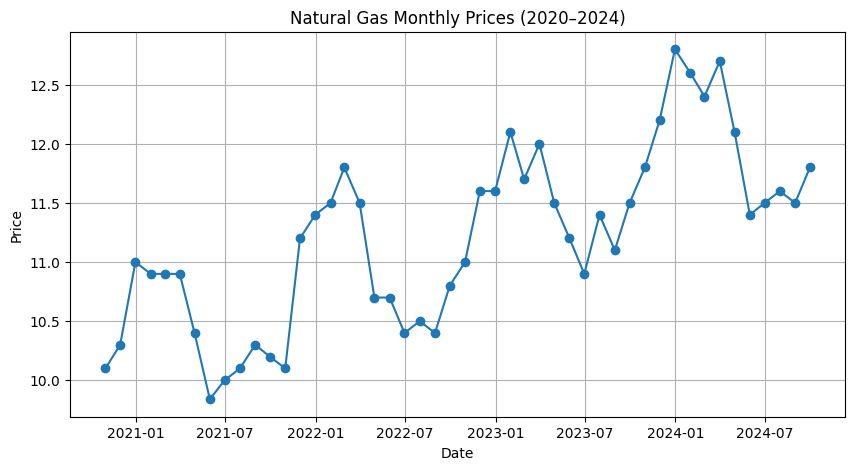

In [3]:
plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Price"], marker="o")
plt.title("Natural Gas Monthly Prices (2020–2024)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


# Add Seasonality

In [4]:
seasonality_factor = {
    1:1.10, 2:1.12, 3:1.05, 4:0.98,
    5:0.90, 6:0.88, 7:0.92, 8:0.95,
    9:1.00, 10:1.05, 11:1.08, 12:1.12
}

df["Month"] = df["Date"].dt.month
df["SeasonalPrice"] = df["Price"] * df["Month"].map(seasonality_factor)

df.head()


,Date,Price,Month,SeasonalPrice
0,2020-10-31,10.1,10,10.605
1,2020-11-30,10.3,11,11.124
2,2020-12-31,11.0,12,12.320
3,2021-01-31,10.9,1,11.990
4,2021-02-28,10.9,2,12.208


# Convert Monthly → Daily

In [5]:
df_daily = df[["Date", "SeasonalPrice"]].set_index("Date").resample("D").mean()
df_daily["SeasonalPrice"] = df_daily["SeasonalPrice"].interpolate(method="cubic")

df_daily.head()


,SeasonalPrice
Date,
2020-10-31,10.605000
2020-11-01,10.575948
2020-11-02,10.551260
2020-11-03,10.530809
2020-11-04,10.514471


# Extrapolate 1 Year into the Future

In [6]:
last_date = df_daily.index.max()
future_dates = pd.date_range(last_date + timedelta(days=1), periods=365)

last_30 = df_daily["SeasonalPrice"][-30:]
daily_slope = (last_30.iloc[-1] - last_30.iloc[0]) / 29  # trend

future_prices = last_30.iloc[-1] + daily_slope * np.arange(1, 366)

df_future = pd.DataFrame({
    "SeasonalPrice": future_prices
}, index=future_dates)

df_extended = pd.concat([df_daily, df_future])
df_extended.tail()


,SeasonalPrice
2025-09-26,22.549221
2025-09-27,22.578997
2025-09-28,22.608774
2025-09-29,22.638550
2025-09-30,22.668326


#Create the get_price() Function

In [7]:
def get_price(date_str):
    date = pd.to_datetime(date_str)

    if date < df_extended.index.min():
        return float(df_extended.iloc[0]["SeasonalPrice"])

    if date in df_extended.index:
        return float(df_extended.loc[date]["SeasonalPrice"])

    if df_extended.index.min() <= date <= df_extended.index.max():
        return float(np.interp(
            date.timestamp(),
            df_extended.index.astype(np.int64) // 10**9,
            df_extended["SeasonalPrice"]
        ))

    extra_days = (date - df_extended.index.max()).days
    return float(df_extended.iloc[-1]["SeasonalPrice"] + daily_slope * extra_days)


In [8]:
print("Price on 2023-06-15:", get_price("2023-06-15"))
print("Price on 2025-05-10:", get_price("2025-05-10"))
print("Price on 2026-01-01:", get_price("2026-01-01"))


Price on 2023-06-15: 9.664057958144921
Price on 2025-05-10: 18.410324328118683
Price on 2026-01-01: 25.437515956208813


# Plot Final Daily + Future Curve

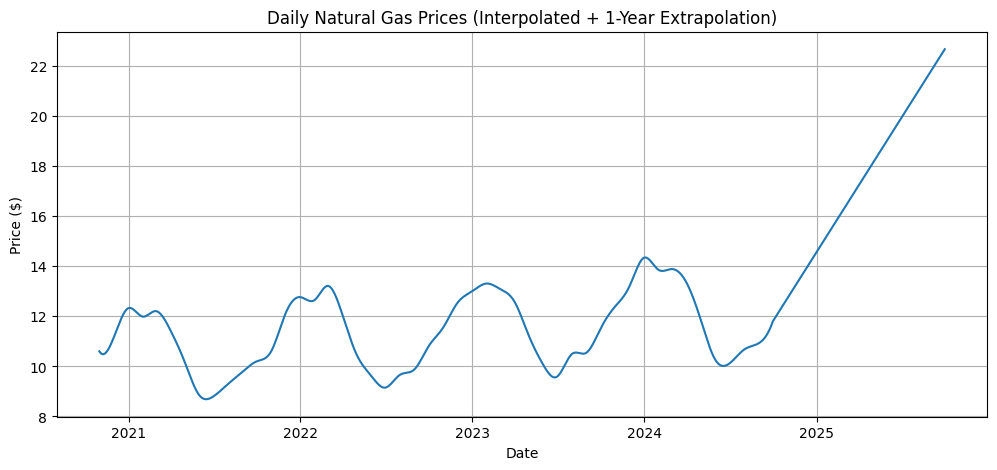

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df_extended.index, df_extended["SeasonalPrice"])
plt.title("Daily Natural Gas Prices (Interpolated + 1-Year Extrapolation)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()
